In [60]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import palettable

In [61]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

data["id"] = [i for i in range(len(data))]
data["time"] = data.index
data = data.set_index("id")
all_years = []
all_month = []
for t in range(len(data)):
    all_years.append(data["time"][t].year)
    all_month.append(data["time"][t].month)
data["year"] = all_years
data["month"] = all_month
data = data.drop(["time"], axis=1)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76,
             7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61,
             7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56,
             7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68,
             7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43,
             7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26,
             7591: 5,  7607: 40, 7621: 65, 7627: 9,  7630: 31,
             7643: 34, 7650: 13, 7661: 83, 7690: 6,  7747: 66,
             7761: 91, 67005: 10}

stations = data["id_sta"].unique()
unwanted_stations = []
for i in stations:
    if i not in provinces:
        unwanted_stations.append(i)
for i in unwanted_stations:
    data = data.drop(data[data["id_sta"] == i].index)

temp_province = []
for i in data["id_sta"]:
    temp_province.append(provinces[i])
data["province"] = temp_province
data = data.drop(["id_sta"], axis=1)

years = data["year"].unique()
provinces = data["province"].unique()
crops = production["crop"].unique()
n_deps = production["n_dep"].unique()

working_month = {"OP" : [3, 4, 5, 6, 7, 8],                   "CZH": [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7],
                 "BTH": [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7], "TS" : [3, 4, 5, 6, 7, 8, 9, 10, 11],
                 "BTP": [2, 3, 4, 5, 6, 7, 8],                "BDP": [2, 3, 4, 5, 6, 7, 8],
                 "BDH": [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7], "OH" : [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7],
                 "MA" : [4, 5, 6, 7, 8, 9, 10, 11]}

In [62]:
def read_in_Y(crop, consider_part):
    map_crop = production['crop'].map(lambda x: x == crop)
    crop_value = production[map_crop]

    for n in n_deps:
        map_province = crop_value['n_dep'].map(lambda x: x == n)
        crop_n_value = crop_value[map_province]

        for y in years:
            if len(crop_n_value[consider_part + "_" + str(y)].values):
                rdt_value = crop_n_value[consider_part + "_" + str(y)].values[0]
                if rdt_value:
                    crop_Y_year[crop + "_" + str(int(n)) + "_" + str(y)] = rdt_value


def X_devide_region(consider_X):
    for p in provinces:
        temp_p_data = data[data["province"].map(lambda x: x == p)]
        for y in years:
            temp_py_data = temp_p_data[temp_p_data["year"].map(lambda x: x == y)]

            if temp_py_data[consider_X[0]].tolist():
                for x in consider_X:
                    name = str(p) + "_" + str(y)
                    if name not in X_region_year:
                        X_region_year[name] = [temp_py_data[x].tolist()]
                    else:
                        X_region_year[name].append(temp_py_data[x].tolist())


def normalize_X():
    for i in X_region_year:
        X_region_year_normalized[i] = []
        for j in X_region_year[i]:
            temp_array = np.array(j)
            X_region_year_normalized[i].append(((temp_array - temp_array.min()) / (temp_array.max() - temp_array.min())).tolist())


def init_list(crop):
    X = []
    Y = []

    for i in X_region_year_normalized_average:
        if crop + "_" + i in crop_Y_year:
            X.append(X_region_year_normalized_average[i])
            Y.append(crop_Y_year[crop + "_" + i])

    return np.array(X), np.array(Y)


def correlation(X, Y):
    avg_X = np.average(X)
    avg_Y = np.average(Y)

    cr = 0
    nx = 0
    ny = 0
    for i in range(len(X)):
        cr += (X[i] - avg_X) * (Y[i] - avg_Y)
        nx += (X[i] - avg_X) ** 2
        ny += (Y[i] - avg_Y) ** 2

    r = cr / (math.sqrt(nx) * math.sqrt(ny))
    return r

In [63]:
consider_parts = list(data.columns)
consider_parts.remove('year')
consider_parts.remove('month')
consider_parts.remove('province')
consider_parts.remove('cumul_DJ_0')
consider_parts.remove('cumul_DJ_6')
consider_parts.remove('cumul_rr24')

correlations = {}
correlations_list = []

for consider_part in consider_parts:
    X_region_year = {}
    X_region_year_normalized = {}
    X_region_year_normalized_average = {}
    crops_Y_year = {}
    correlations_list.append([])

    X_devide_region([consider_part])
    normalize_X()
    for i in X_region_year_normalized:
        X_region_year_normalized_average[i] = np.average(X_region_year_normalized[i][0])

    Y_province = {}
    for crop in crops:
        crop_Y_year = {}
        read_in_Y(crop, "rdt")
        crops_Y_year[crop] = crop_Y_year

        X, Y = init_list(crop)
        correlations[crop + "_" + consider_part] = correlation(np.array(X), np.array(Y))
        correlations_list[-1].append(correlations[crop + "_" + consider_part])

In [64]:
correlations_list

[[0.33118281017762496,
  0.4305669635649405,
  0.4213647322373563,
  0.1752272938423842,
  0.321240747053846,
  0.1904327082993299,
  0.1904327082993299,
  0.39442498846887575,
  0.2149685443845211],
 [-0.019045815080277414,
  0.00486831300472709,
  -0.09599310201495571,
  0.07790940777165427,
  -0.055940278519265516,
  -0.06486178534756518,
  -0.06486178534756518,
  -0.045414620454267605,
  0.13980060838512334],
 [-0.12670890840616736,
  0.0654264204950251,
  -0.14725890549632825,
  0.1851270031569187,
  -0.1595214413444728,
  -0.08958223603458143,
  -0.08958223603458143,
  -0.10112180316503117,
  0.3254087617673672],
 [0.03368085192278749,
  0.05765671120533276,
  -0.0379051754089612,
  0.04307299377066226,
  0.010166423875610165,
  0.021439333882089608,
  0.021439333882089608,
  -0.01522755716541361,
  0.1892243718027442],
 [-0.01907926706825938,
  0.12549374215595702,
  -0.05894449055856226,
  0.14634238494949522,
  -0.061668587395576784,
  -0.01356108590612651,
  -0.01356108590612

<AxesSubplot:ylabel='type'>

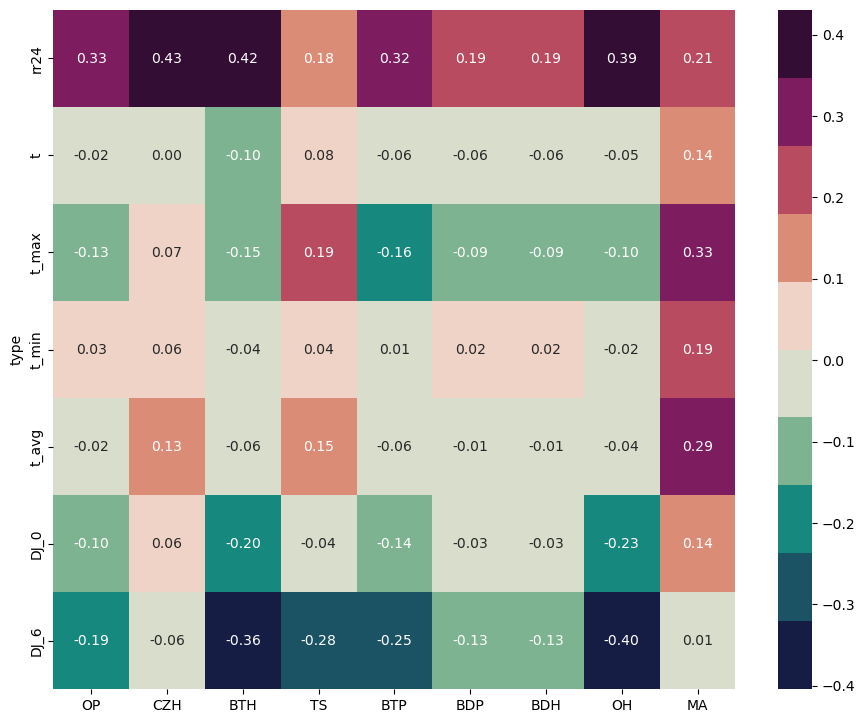

In [73]:
c_plot = pd.DataFrame(data=correlations_list, columns=crops)
c_plot["type"] = consider_parts
c_plot = c_plot.set_index("type")

plt.figure(figsize=(11, 9), dpi=100)
sns.heatmap(c_plot, fmt=".2f", annot=True, cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)

In [3]:
def read_in_Y(crop, consider_part):
    map_crop = production['crop'].map(lambda x: x == crop)
    crop_value = production[map_crop]

    for n in n_deps:
        map_province = crop_value['n_dep'].map(lambda x: x == n)
        crop_n_value = crop_value[map_province]

        for y in years:
            if len(crop_n_value[consider_part + "_" + str(y)].values):
                rdt_value = crop_n_value[consider_part + "_" + str(y)].values[0]
                if rdt_value:
                    crop_Y_year[crop + "_" + str(int(n)) + "_" + str(y)] = rdt_value


def X_devide_region(consider_X):
    for p in provinces:
        temp_p_data = data[data["province"].map(lambda x: x == p)]
        for y in years:
            temp_py_data = temp_p_data[temp_p_data["year"].map(lambda x: x == y)]
            for m in range(1, 13):
                temp_pym_data = temp_py_data[temp_py_data["month"].map(lambda x: x == m)]
                if consider_X[0] in temp_pym_data and temp_pym_data[consider_X[0]].tolist():
                    for x in consider_X:
                        name = str(p) + "_" + str(y) + "_" + str(m)
                        if name not in X_region_year_month:
                            X_region_year_month[name] = [temp_pym_data[x].tolist()]
                        else:
                            X_region_year_month[name].append(temp_pym_data[x].tolist())


def normalize_X():
    for i in X_region_year_month:
        X_region_year_month_normalized[i] = []
        for j in X_region_year_month[i]:
            temp_array = np.array(j)
            max_X, min_X = max(temp_array), min(temp_array)
            if max_X - min_X > 1.0e-15:
                X_region_year_month_normalized[i].append(((temp_array - min_X) / (max_X - min_X)).tolist())
            else:
                X_region_year_month_normalized[i].append([len(j) - 1 for _ in j])


def init_list(crop):
    X = []
    Y = []

    for i in X_region_year_normalized_average:
        p, y, m = i.split("_")
        name = crop + "_" + p + "_" + y
        if name in crop_Y_year:
            X.append(X_region_year_normalized_average[i])
            Y.append(crop_Y_year[name])

    return np.array(X), np.array(Y)


def correlation(X, Y):
    avg_X = np.average(X)
    avg_Y = np.average(Y)

    cr = 0
    nx = 0
    ny = 0
    for i in range(len(X)):
        cr += (X[i] - avg_X) * (Y[i] - avg_Y)
        nx += (X[i] - avg_X) ** 2
        ny += (Y[i] - avg_Y) ** 2

    r = cr / (math.sqrt(nx) * math.sqrt(ny))
    return r

<AxesSubplot:ylabel='type'>

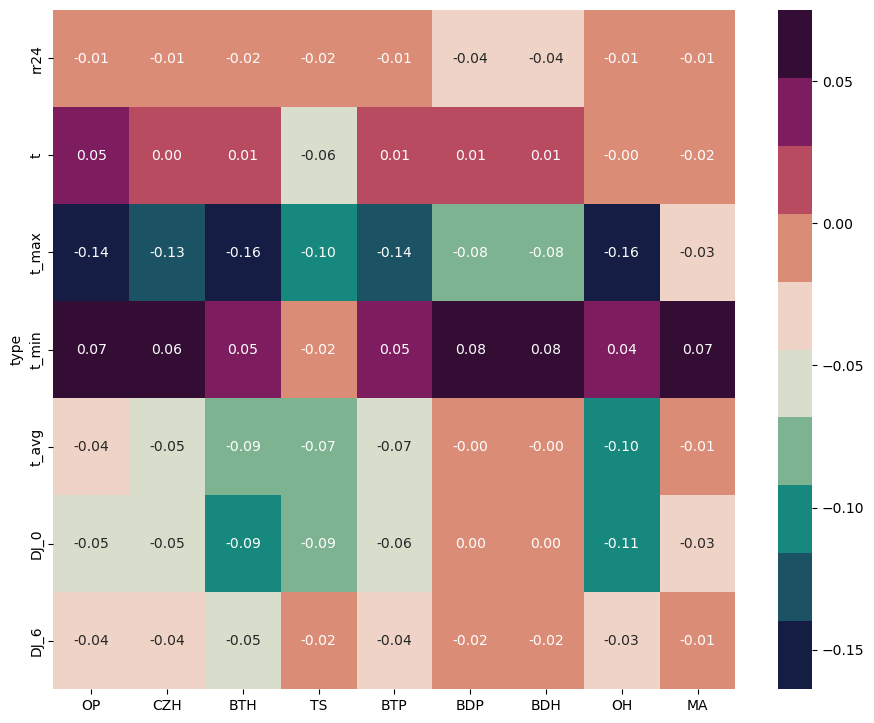

In [4]:
consider_parts = list(data.columns)
consider_parts.remove('year')
consider_parts.remove('month')
consider_parts.remove('province')
consider_parts.remove('cumul_DJ_0')
consider_parts.remove('cumul_DJ_6')
consider_parts.remove('cumul_rr24')

correlations = {}
correlations_list = []

for consider_part in consider_parts:
    X_region_year_month = {}
    X_region_year_month_normalized = {}
    X_region_year_normalized_average = {}
    crops_Y_year = {}
    correlations_list.append([])

    X_devide_region([consider_part])
    normalize_X()
    for i in X_region_year_month_normalized:
        X_region_year_normalized_average[i] = np.average(X_region_year_month_normalized[i][0])

    Y_province = {}
    for crop in crops:
        crop_Y_year = {}
        read_in_Y(crop, "rdt")
        crops_Y_year[crop] = crop_Y_year

        X, Y = init_list(crop)
        correlations[crop + "_" + consider_part] = correlation(X, Y)
        correlations_list[-1].append(correlations[crop + "_" + consider_part])

c_plot = pd.DataFrame(data=correlations_list, columns=crops)
c_plot["type"] = consider_parts
c_plot = c_plot.set_index("type")

plt.figure(figsize=(11, 9), dpi=100)
sns.heatmap(c_plot, fmt=".2f", annot=True, cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)

In [51]:
years = [2018, 2019, 2020, 2021]
provinces = np.delete(provinces, [2, 7, -3])

<AxesSubplot:ylabel='type'>

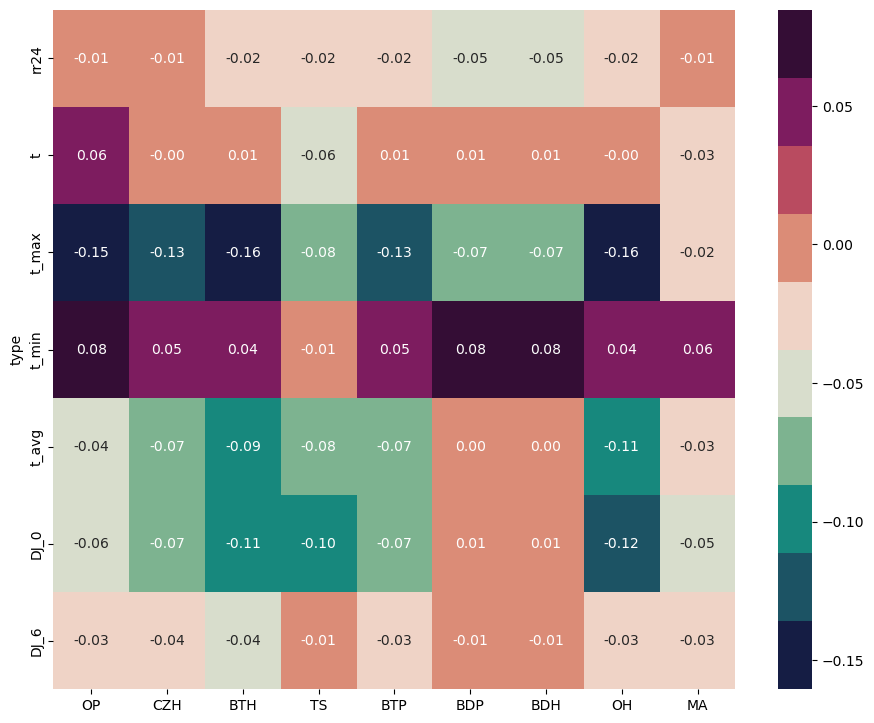

In [52]:
consider_parts = list(data.columns)
consider_parts.remove('year')
consider_parts.remove('month')
consider_parts.remove('province')
consider_parts.remove('cumul_DJ_0')
consider_parts.remove('cumul_DJ_6')
consider_parts.remove('cumul_rr24')

correlations = {}
correlations_list = []

for consider_part in consider_parts:
    X_region_year_month = {}
    X_region_year_month_normalized = {}
    X_region_year_normalized_average = {}
    crops_Y_year = {}
    correlations_list.append([])

    X_devide_region([consider_part])
    normalize_X()
    for i in X_region_year_month_normalized:
        X_region_year_normalized_average[i] = np.average(X_region_year_month_normalized[i][0])

    Y_province = {}
    for crop in crops:
        crop_Y_year = {}
        read_in_Y(crop, "rdt")
        crops_Y_year[crop] = crop_Y_year

        X, Y = init_list(crop)
        correlations[crop + "_" + consider_part] = correlation(X, Y)
        correlations_list[-1].append(correlations[crop + "_" + consider_part])

c_plot = pd.DataFrame(data=correlations_list, columns=crops)
c_plot["type"] = consider_parts
c_plot = c_plot.set_index("type")

plt.figure(figsize=(11, 9), dpi=100)
sns.heatmap(c_plot, fmt=".2f", annot=True, cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)

In [53]:
def read_in_Y(crop, consider_part):
    map_crop = production['crop'].map(lambda x: x == crop)
    crop_value = production[map_crop]

    for n in n_deps:
        map_province = crop_value['n_dep'].map(lambda x: x == n)
        crop_n_value = crop_value[map_province]

        for y in years:
            if len(crop_n_value[consider_part + "_" + str(y)].values):
                rdt_value = crop_n_value[consider_part + "_" + str(y)].values[0]
                if rdt_value:
                    crop_Y_year[crop + "_" + str(int(n)) + "_" + str(y)] = rdt_value


def X_devide_region(consider_X):
    for p in provinces:
        temp_p_data = data[data["province"].map(lambda x: x == p)]
        for y in years:
            temp_py_data = temp_p_data[temp_p_data["year"].map(lambda x: x == y)]
            for m in range(1, 13):
                temp_pym_data = temp_py_data[temp_py_data["month"].map(lambda x: x == m)]
                if consider_X[0] in temp_pym_data and temp_pym_data[consider_X[0]].tolist():
                    for x in consider_X:
                        name = str(p) + "_" + str(y) + "_" + str(m)
                        if name not in X_region_year_month:
                            X_region_year_month[name] = [temp_pym_data[x].tolist()]
                        else:
                            X_region_year_month[name].append(temp_pym_data[x].tolist())


def normalize_X():
    for i in X_region_year_month:
        X_region_year_month_normalized[i] = []
        for j in X_region_year_month[i]:
            temp_array = np.array(j)
            max_X, min_X = max(temp_array), min(temp_array)
            if max_X - min_X > 1.0e-15:
                X_region_year_month_normalized[i].append(((temp_array - min_X) / (max_X - min_X)).tolist())
            else:
                X_region_year_month_normalized[i].append([len(j) - 1 for _ in j])


def init_list(crop):
    X = []
    Y = []

    for i in X_region_year_normalized_average:
        p, y, m = i.split("_")
        if int(m) in working_month[crop]:
            name = crop + "_" + p + "_" + y
            if name in crop_Y_year:
                X.append(X_region_year_normalized_average[i])
                Y.append(crop_Y_year[name])

    return np.array(X), np.array(Y)


def correlation(X, Y):
    avg_X = np.average(X)
    avg_Y = np.average(Y)

    cr = 0
    nx = 0
    ny = 0
    for i in range(len(X)):
        cr += (X[i] - avg_X) * (Y[i] - avg_Y)
        nx += (X[i] - avg_X) ** 2
        ny += (Y[i] - avg_Y) ** 2

    r = cr / (math.sqrt(nx) * math.sqrt(ny))
    return r

<AxesSubplot:ylabel='type'>

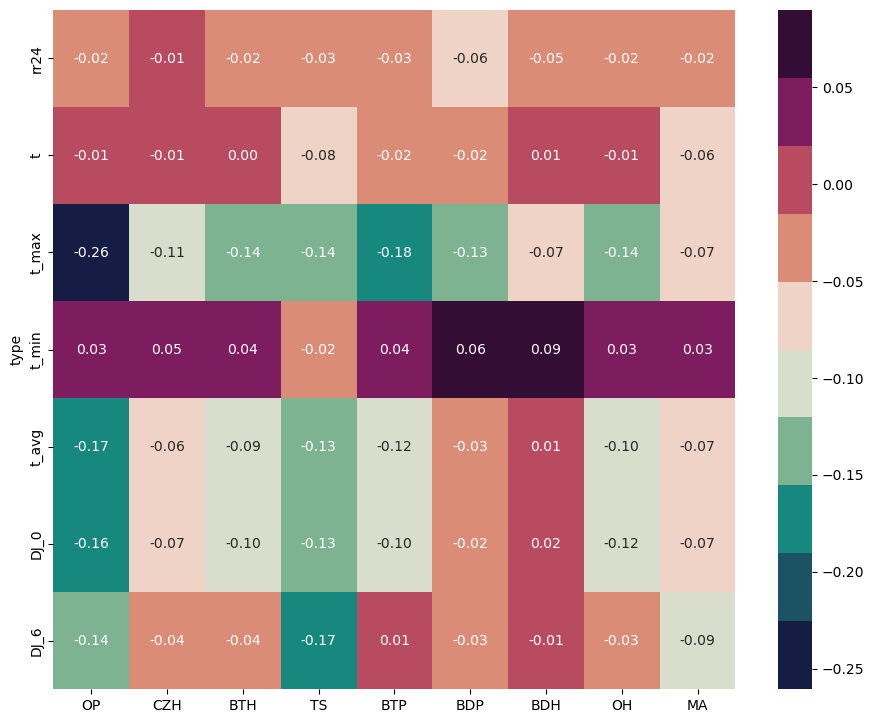

In [54]:
consider_parts = list(data.columns)
consider_parts.remove('year')
consider_parts.remove('month')
consider_parts.remove('province')
consider_parts.remove('cumul_DJ_0')
consider_parts.remove('cumul_DJ_6')
consider_parts.remove('cumul_rr24')

correlations = {}
correlations_list = []

for consider_part in consider_parts:
    X_region_year_month = {}
    X_region_year_month_normalized = {}
    X_region_year_normalized_average = {}
    crops_Y_year = {}
    correlations_list.append([])

    X_devide_region([consider_part])
    normalize_X()
    for i in X_region_year_month_normalized:
        X_region_year_normalized_average[i] = np.average(X_region_year_month_normalized[i][0])

    Y_province = {}
    for crop in crops:
        crop_Y_year = {}
        read_in_Y(crop, "rdt")
        crops_Y_year[crop] = crop_Y_year

        X, Y = init_list(crop)
        correlations[crop + "_" + consider_part] = correlation(X, Y)
        correlations_list[-1].append(correlations[crop + "_" + consider_part])

c_plot = pd.DataFrame(data=correlations_list, columns=crops)
c_plot["type"] = consider_parts
c_plot = c_plot.set_index("type")

plt.figure(figsize=(11, 9), dpi=100)
sns.heatmap(c_plot, fmt=".2f", annot=True, cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)

In [77]:
def read_in_Y(crop, consider_part):
    map_crop = production['crop'].map(lambda x: x == crop)
    crop_value = production[map_crop]

    for n in n_deps:
        map_province = crop_value['n_dep'].map(lambda x: x == n)
        crop_n_value = crop_value[map_province]

        for y in years:
            if len(crop_n_value[consider_part + "_" + str(y)].values):
                rdt_value = crop_n_value[consider_part + "_" + str(y)].values[0]
                if rdt_value:
                    crop_Y_year[crop + "_" + str(int(n)) + "_" + str(y)] = rdt_value


def X_devide_region(consider_X):
    for p in provinces:
        temp_p_data = data[data["province"].map(lambda x: x == p)]
        for y in years:
            temp_py_data = temp_p_data[temp_p_data["year"].map(lambda x: x == y)]
            for m in range(1, 13):
                temp_pym_data = temp_py_data[temp_py_data["month"].map(lambda x: x == m)]
                if consider_X[0] in temp_pym_data and temp_pym_data[consider_X[0]].tolist():
                    for x in consider_X:
                        name = str(p) + "_" + str(y) + "_" + str(m)
                        if name not in X_region_year_month:
                            X_region_year_month[name] = [temp_pym_data[x].tolist()]
                        else:
                            X_region_year_month[name].append(temp_pym_data[x].tolist())


def normalize_X():
    for i in X_region_year_month:
        X_region_year_month_normalized[i] = []
        for j in X_region_year_month[i]:
            temp_array = np.array(j)
            max_X, min_X = max(temp_array), min(temp_array)
            if max_X - min_X > 1.0e-15:
                X_region_year_month_normalized[i].append(((temp_array - min_X) / (max_X - min_X)).tolist())
            else:
                X_region_year_month_normalized[i].append([len(j) - 1 for _ in j])


def init_list(crop, consider_part, month):
    X = []
    Y = []

    temp_X = {}
    for i in X_region_year_normalized_average:
        temp_X[i] = X_region_year_normalized_average[i][consider_part]

    for i in temp_X:
        p, y, m = i.split("_")
        if int(m) == month:
            name = crop + "_" + p + "_" + y
            if name in crop_Y_year:
                X.append(temp_X[i])
                Y.append(crop_Y_year[name])

    return np.array(X), np.array(Y)


def correlation(X, Y):
    avg_X = np.average(X)
    avg_Y = np.average(Y)

    cr = 0
    nx = 0
    ny = 0
    for i in range(len(X)):
        cr += (X[i] - avg_X) * (Y[i] - avg_Y)
        nx += (X[i] - avg_X) ** 2
        ny += (Y[i] - avg_Y) ** 2

    r = cr / (math.sqrt(nx) * math.sqrt(ny))
    return r


consider_parts = ["rr24", "t_avg"]

consider_parts_list = []
correlations = {}
correlations_list = []
X_region_year_month = {}
X_region_year_month_normalized = {}
X_region_year_normalized_average = {}
crops_Y_year = {}

X_devide_region(consider_parts)
normalize_X()
for i in X_region_year_month_normalized:
    X_region_year_normalized_average[i] = []
    for j in range(len(X_region_year_month_normalized[i])):
        X_region_year_normalized_average[i].append(np.average(X_region_year_month_normalized[i][j]))

Y_province = {}
for crop in crops:
    if crop not in crops_Y_year:
        crop_Y_year = {}
        read_in_Y(crop, "rdt")
        crops_Y_year[crop] = crop_Y_year

for cp in range(len(consider_parts)):
    for m in range(1, 13):
        correlations_list.append([])
        consider_parts_list.append(consider_parts[cp] + "_" + str(m))
        for crop in crops:
            crop_Y_year = crops_Y_year[crop]
            X, Y = init_list(crop, cp, m)
            correlations[crop + "_" + consider_parts[cp] + "_" + str(m)] = correlation(X, Y)
            correlations_list[-1].append(correlations[crop + "_" + consider_parts[cp] + "_" + str(m)])

In [73]:
correlations_list

[[0.29154098429394576,
  0.22570118007631718,
  0.2546918927532706,
  0.3367061316531368,
  0.21833550940717153,
  0.0823405718145965,
  0.0823405718145965,
  0.3057183949222222,
  0.19379798232367723],
 [-0.0165646439750007,
  0.17495076344255717,
  0.09800476184774798,
  0.05834096600999468,
  0.12078184920281833,
  -0.0006479242230795245,
  -0.0006479242230795245,
  0.023589583446667957,
  0.06901549165865097],
 [0.03400549859867646,
  0.14706967331066176,
  0.021533251257412754,
  0.09906163590110573,
  0.002696242487307769,
  -0.07069847448126935,
  -0.07069847448126935,
  0.06391171575407904,
  0.17589524501080997],
 [0.07681182447243372,
  0.0356387153713712,
  0.02998792459509681,
  -0.11362755949738518,
  0.0484614106481657,
  0.09332670280933493,
  0.09332670280933493,
  0.0406631755539631,
  0.0075083507733746556],
 [0.03829347223532532,
  0.15238505716308204,
  0.03330393368963174,
  0.21686136224143537,
  -0.005354339330497113,
  -0.034415898816945824,
  -0.034415898816945

In [74]:
consider_parts_list

['rr24_1',
 'rr24_2',
 'rr24_3',
 'rr24_4',
 'rr24_5',
 'rr24_6',
 'rr24_7',
 'rr24_8',
 'rr24_9',
 'rr24_10',
 'rr24_11',
 'rr24_12',
 't_avg_1',
 't_avg_2',
 't_avg_3',
 't_avg_4',
 't_avg_5',
 't_avg_6',
 't_avg_7',
 't_avg_8',
 't_avg_9',
 't_avg_10',
 't_avg_11',
 't_avg_12']

<AxesSubplot:ylabel='type'>

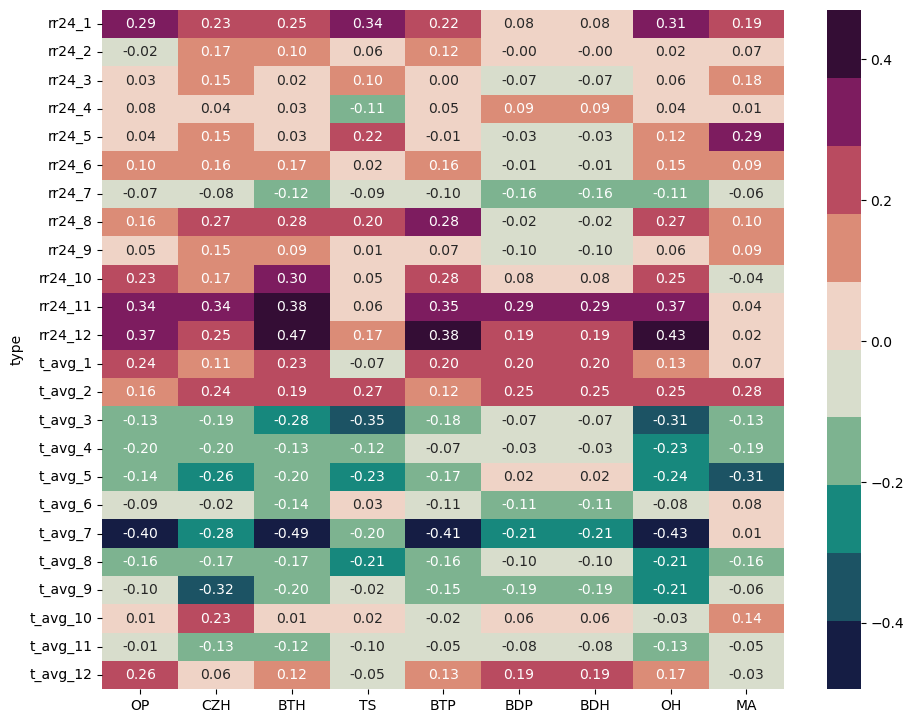

In [78]:
c_plot = pd.DataFrame(data=correlations_list, columns=crops)
c_plot["type"] = consider_parts_list
c_plot = c_plot.set_index("type")

plt.figure(figsize=(11, 9), dpi=100)
sns.heatmap(c_plot, fmt=".2f", annot=True, cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)